In [72]:
import pandas as pd
import psycopg2 as pg
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timezone
import seaborn as sns
import random

In [73]:
connection_args = {
    'host': 'euw-postgres.onitsoft.com',
    'dbname': 'bot_detector',
    'port': 5432,
    'user': 'postgres',
    'password': 'Os5ef.7Q{8j!?7R'
}

connection = pg.connect(**connection_args)  

In [74]:
bot_offset = random.randint(0, 100000)
human_offset = random.randint(0, 100000)

bots_df = pd.read_sql(f'SELECT * FROM users where bot = true offset {bot_offset} limit 25000', connection)
humans_df = pd.read_sql(f'SELECT * FROM users where bot = false offset {human_offset} limit 50000', connection)

/tmp/ipykernel_1194758/129945631.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  bots_df = pd.read_sql(f'SELECT * FROM users where bot = true offset {bot_offset} limit 25000', connection)
/tmp/ipykernel_1194758/129945631.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  humans_df = pd.read_sql(f'SELECT * FROM users where bot = false offset {human_offset} limit 50000', connection)


In [75]:
raw_df = pd.concat([bots_df, humans_df])

In [76]:
raw_df["account_age_days"] = (datetime(year=2022, month=5, day=15, tzinfo=timezone.utc) - raw_df["created_at"]).apply(lambda d: d.days)
raw_df["average_tweets_per_day"] = raw_df["tweet_count"] / raw_df["account_age_days"]

In [77]:
humans_df.head()

,id,username,follower_count,location,verified,bot,display_name,following_count,tweet_count,listed_count,default_profile_image,account_description,geo_enabled,pinned_tweet,protected,description_urls_count,description_mentions_count,account_age_days,average_tweets_per_day,created_at
0,twitter_204982635,RobotDiva,10617,None,False,False,Erin Bishop ✨,1466,7260,375,False,#ROBOTS ARE HAPPENING💥 Follow me for #Robots 🤖...,True,False,False,0,0,0,0,2010-10-19 22:22:32+00:00
1,twitter_16352993,heatherknight,6432,None,False,False,Heather Knight,516,3750,385,False,@OregonState robotics professor with a soft sp...,False,False,False,0,3,0,0,2008-09-18 20:49:39+00:00
2,twitter_4288099702,robolegist,6948,None,False,False,Selin Çetin,1049,4907,51,False,#robolegist | The General Secretary of Istanbu...,False,False,False,0,0,0,0,2015-11-26 18:35:44+00:00
3,twitter_1220735833503715329,CodedBias,5715,None,False,False,Coded Bias Documentary,163,2242,68,False,"""A chilling plunge into Orwellian reality."" - ...",True,True,False,0,2,0,0,2020-01-24 15:51:40+00:00
4,twitter_2778277496,AJLUnited,28224,None,True,False,Algorithmic Justice League,1251,1837,503,False,Join the Algorithmic Justice League in the mov...,True,True,False,1,0,0,0,2014-08-29 11:14:47+00:00


In [78]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75000 entries, 0 to 49999
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   id                          75000 non-null  object             
 1   username                    75000 non-null  object             
 2   follower_count              75000 non-null  int64              
 3   location                    0 non-null      object             
 4   verified                    75000 non-null  bool               
 5   bot                         75000 non-null  bool               
 6   display_name                75000 non-null  object             
 7   following_count             75000 non-null  int64              
 8   tweet_count                 75000 non-null  int64              
 9   listed_count                75000 non-null  int64              
 10  default_profile_image       75000 non-null  bool               

In [79]:
print(raw_df[raw_df["bot"] == True].count()["id"])
print(raw_df[raw_df["bot"] == False].count()["id"])

25000
50000


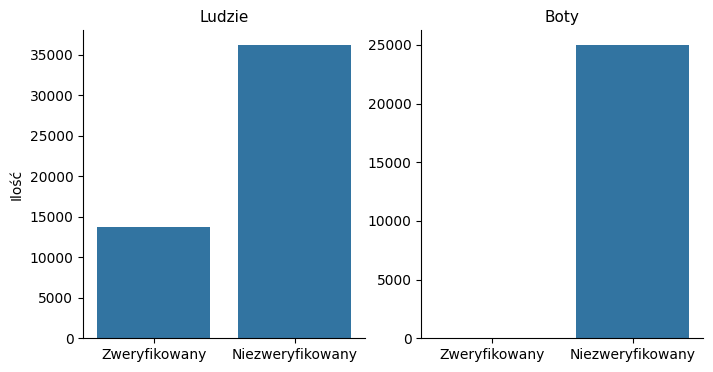

In [80]:
bots_verified = len(bots_df[bots_df["verified"] == True])
bots_not_verified = len(bots_df[bots_df["verified"] == False])

humans_verified = len(humans_df[humans_df["verified"] == True])
humans_not_verified = len(humans_df[humans_df["verified"] == False])

types = ["Zweryfikowany", "Niezweryfikowany"]
bot_counts = [bots_verified, bots_not_verified]
human_counts = [humans_verified, humans_not_verified]

plt.figure(figsize=(8, 4), dpi=100)
# plt.suptitle("Ilość kont ze względu na weryfikacje", fontsize=12)

plt.subplot(1, 2, 1)
sns.barplot(x = types, y = human_counts)
plt.title("Ludzie", fontsize=11)
plt.ylabel("Ilość", fontsize=10)
sns.despine()

plt.subplot(1, 2, 2)
sns.barplot(x = types, y = bot_counts)
plt.title("Boty", fontsize=11)
sns.despine()

In [81]:
raw_df.drop(columns=['id', 'location'], inplace=True)
raw_df['default_profile_image'] = raw_df['default_profile_image'].astype(int)
raw_df['pinned_tweet'] = raw_df['pinned_tweet'].astype(int)
raw_df['protected'] = raw_df['protected'].astype(int)
raw_df['geo_enabled'] = raw_df['geo_enabled'].astype(int)
raw_df['verified'] = raw_df['verified'].astype(int)
raw_df['created_at'] = pd.to_datetime(raw_df['created_at'])
raw_df['hour_created'] = pd.to_datetime(raw_df['created_at']).dt.hour
raw_df['bot'] = raw_df['bot'].astype(int)

In [112]:
df = raw_df[['bot', 'hour_created', 'verified', 'geo_enabled', 'default_profile_image', 'following_count', 'follower_count', 'listed_count', 'pinned_tweet', 'protected', 'description_urls_count', 'description_mentions_count', 'account_age_days', 'average_tweets_per_day']]

In [113]:
df.head()

,bot,hour_created,verified,geo_enabled,default_profile_image,following_count,follower_count,listed_count,pinned_tweet,protected,description_urls_count,description_mentions_count,account_age_days,average_tweets_per_day
0,1,14,0,0,0,204,77,0,0,0,0,0,3380,0.007101
1,1,0,0,0,0,81,6,0,0,0,0,0,3859,0.000000
2,1,4,0,0,0,42,0,0,0,0,0,0,132,0.000000
3,1,7,0,1,0,207,4,0,1,1,0,0,2661,0.308155
4,1,16,0,1,0,815,16,0,0,0,0,0,177,0.124294


In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   bot                         75000 non-null  int64  
 1   hour_created                75000 non-null  int32  
 2   verified                    75000 non-null  int64  
 3   geo_enabled                 75000 non-null  int64  
 4   default_profile_image       75000 non-null  int64  
 5   following_count             75000 non-null  int64  
 6   follower_count              75000 non-null  int64  
 7   listed_count                75000 non-null  int64  
 8   pinned_tweet                75000 non-null  int64  
 9   protected                   75000 non-null  int64  
 10  description_urls_count      75000 non-null  int64  
 11  description_mentions_count  75000 non-null  int64  
 12  account_age_days            75000 non-null  int64  
 13  average_tweets_per_day      75000 no

In [115]:
df.describe()

,bot,hour_created,verified,geo_enabled,default_profile_image,following_count,follower_count,listed_count,pinned_tweet,protected,description_urls_count,description_mentions_count,account_age_days,average_tweets_per_day
count,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,7.500000e+04,7.500000e+04,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000
mean,0.333333,12.853307,0.183853,0.665173,0.074507,3.425563e+03,1.016041e+05,396.137320,0.386280,0.053800,0.115027,0.508547,2768.254053,6.125579
std,0.471408,6.622310,0.387367,0.471933,0.262595,2.892842e+04,5.938734e+05,1436.423518,0.486899,0.225624,0.411968,1.146588,1652.597937,23.756623
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,61.000000,0.000000
25%,0.000000,8.000000,0.000000,0.000000,0.000000,1.820000e+02,6.600000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,1158.750000,0.075895
50%,0.000000,14.000000,0.000000,1.000000,0.000000,5.850000e+02,1.646000e+03,14.000000,0.000000,0.000000,0.000000,0.000000,2988.000000,0.883493
75%,1.000000,18.000000,0.000000,1.000000,0.000000,1.677000e+03,1.809125e+04,212.000000,1.000000,0.000000,0.000000,0.000000,4302.000000,4.245223
max,1.000000,23.000000,1.000000,1.000000,1.000000,2.299664e+06,2.460215e+07,51885.000000,1.000000,1.000000,10.000000,13.000000,5792.000000,1927.078269


In [116]:
# Interesting features to look at: 
df['avg_daily_followers'] = np.round(df['follower_count'] / df['account_age_days'])
df['avg_daily_friends'] = np.round(df['following_count'] / df['account_age_days'])

# Log transformations for highly skewed data
df['following_log'] = np.round(np.log(1 + df['following_count']), 3)
df['follower_log'] = np.round(np.log(1 + df['follower_count']), 3)
df['avg_daily_tweets_log'] = np.round(np.log(1+ df['average_tweets_per_day']), 3)

# Possible interaction features
df['network'] = np.round(df['following_log'] * df['follower_log'], 3)
df['tweet_to_followers'] = np.round(np.log( 1+ df['listed_count']) * np.log(1+ df['follower_count']), 3)

# Log-transformed daily acquisition metrics for dist. plots
df['follower_acq_rate'] = np.round(np.log(1 + (df['follower_count'] / df['account_age_days'])), 3)
df['friends_acq_rate'] = np.round(np.log(1 + (df['following_count'] / df['account_age_days'])), 3)
df['favs_rate'] = np.round(np.log(1 + (df['following_count'] / df['account_age_days'])), 3)

/tmp/ipykernel_1194758/4091692361.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['avg_daily_followers'] = np.round(df['follower_count'] / df['account_age_days'])
/tmp/ipykernel_1194758/4091692361.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['avg_daily_friends'] = np.round(df['following_count'] / df['account_age_days'])
/tmp/ipykernel_1194758/4091692361.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [117]:
df.head()

,bot,hour_created,verified,geo_enabled,default_profile_image,following_count,follower_count,listed_count,pinned_tweet,protected,...,avg_daily_followers,avg_daily_friends,following_log,follower_log,avg_daily_tweets_log,network,tweet_to_followers,follower_acq_rate,friends_acq_rate,favs_rate
0,1,14,0,0,0,204,77,0,0,0,...,0.0,0.0,5.323,4.357,0.007,23.192,0.0,0.023,0.059,0.059
1,1,0,0,0,0,81,6,0,0,0,...,0.0,0.0,4.407,1.946,0.000,8.576,0.0,0.002,0.021,0.021
2,1,4,0,0,0,42,0,0,0,0,...,0.0,0.0,3.761,0.000,0.000,0.000,0.0,0.000,0.276,0.276
3,1,7,0,1,0,207,4,0,1,1,...,0.0,0.0,5.338,1.609,0.269,8.589,0.0,0.002,0.075,0.075
4,1,16,0,1,0,815,16,0,0,0,...,0.0,5.0,6.704,2.833,0.117,18.992,0.0,0.087,1.724,1.724


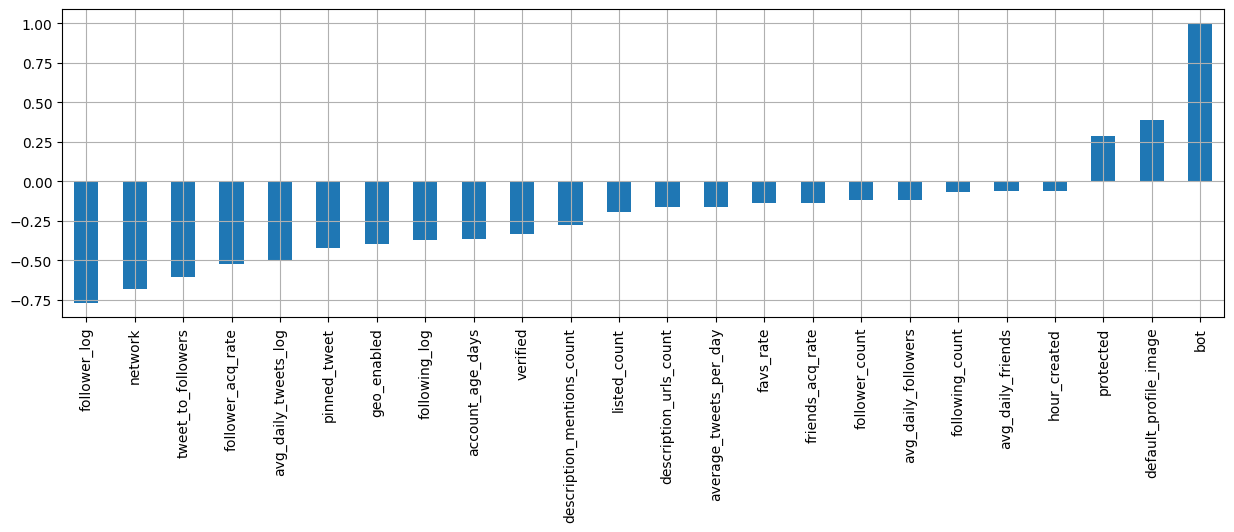

In [118]:
plt.figure(figsize=(15, 4))
df.corr()["bot"].sort_values().plot(kind="bar")
plt.grid()

<Axes: >

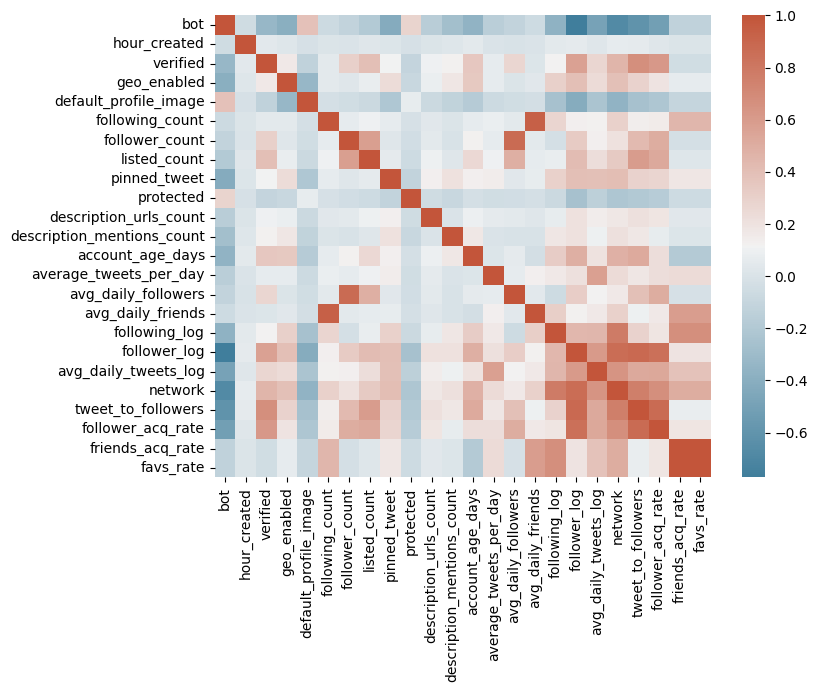

In [119]:
plt.figure(figsize=(8,6), dpi=100)
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(df.corr(), cmap=cmap, annot=False)
# plt.title('Correlation of potential features: all data', fontsize=14)

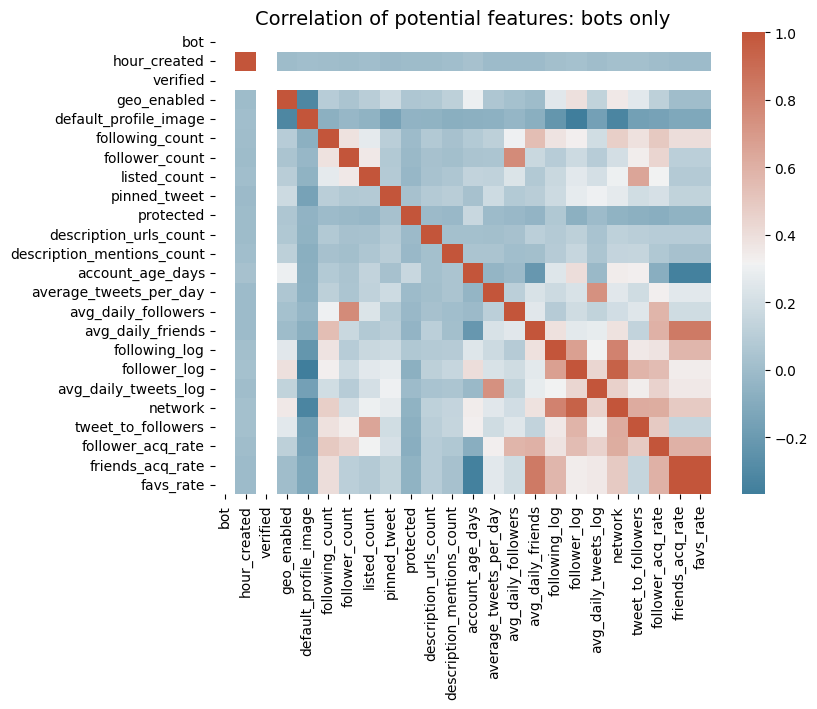

In [120]:
plt.figure(figsize=(8,6), dpi=100)
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(df[df["bot"] == True].corr(), cmap=cmap, annot=False)
plt.title('Correlation of potential features: bots only', fontsize=14);

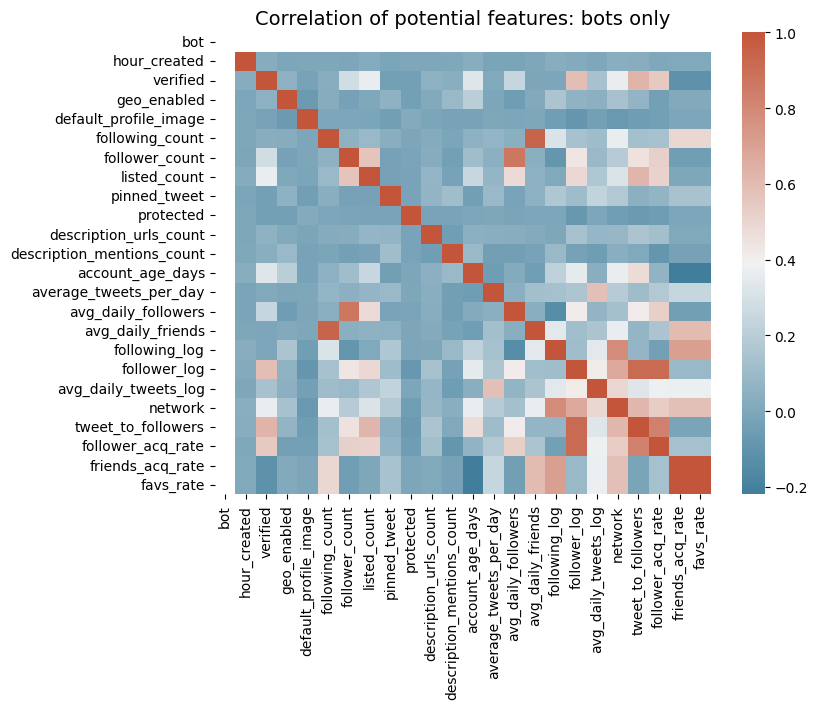

In [121]:
plt.figure(figsize=(8,6), dpi=100)
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(df[df["bot"] == False].corr(), cmap=cmap, annot=False)
plt.title('Correlation of potential features: bots only', fontsize=14);

In [127]:
df_for_plots = df.copy(deep=True)
df_for_plots['Typ konta'] = df_for_plots['bot'].map({1: 'Bot', 0: 'Zwykły użytkownik'})

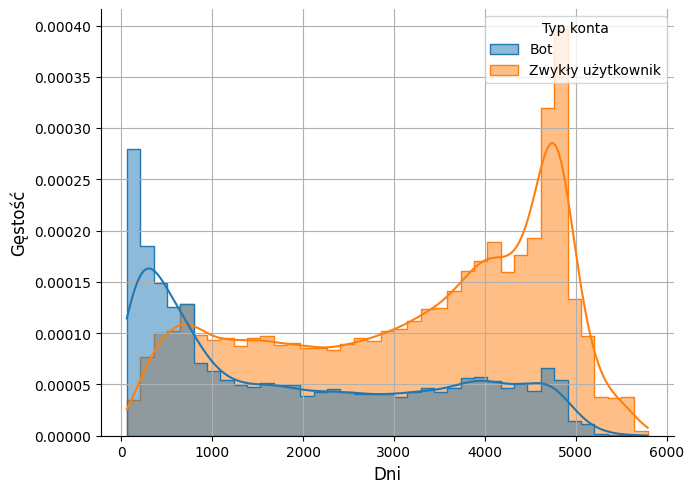

In [134]:
plt.figure(figsize=(7,5), dpi=100)
ax = sns.histplot(
    x='account_age_days', data=df_for_plots, hue='Typ konta', alpha=0.5,
    kde=True, stat='density', common_bins=True, element='step'
)

# plt.legend(labels=['Bot', 'Human'], title='Typ konta', loc='upper left', frameon=False)

# Ensure the layout is adjusted to accommodate the legend
plt.tight_layout()

# Enhancing title and labels
# plt.title('Rozkład dla zmiennej aktywnych dni konta', fontsize=14)
plt.xlabel('Dni', fontsize=12)
plt.ylabel('Gęstość', fontsize=12)

# Optionally, set a grid
plt.grid(True)

# Despine for aesthetics
sns.despine();

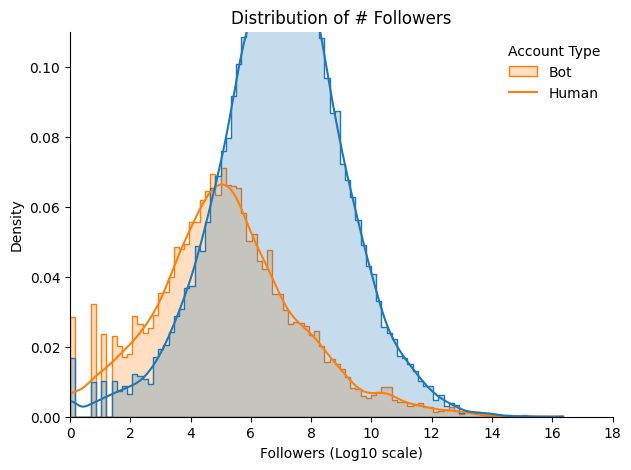

In [21]:
plt.figure(figsize=(7,5), dpi=100)
sns.histplot(x='follower_log', data=df, hue='bot', alpha=.25, 
             kde=True, stat='density', common_bins=True, element='step', legend=True)

plt.legend(title='Account Type', loc='upper right', labels=['Bot', 'Human'], frameon=False)
plt.title('Distribution of # Followers', fontsize=12)
plt.xlabel('Followers (Log10 scale)', fontsize=10)
plt.ylabel('Density', fontsize=10)
plt.xlim(0, 18)
plt.ylim(0, 0.11)
sns.despine()

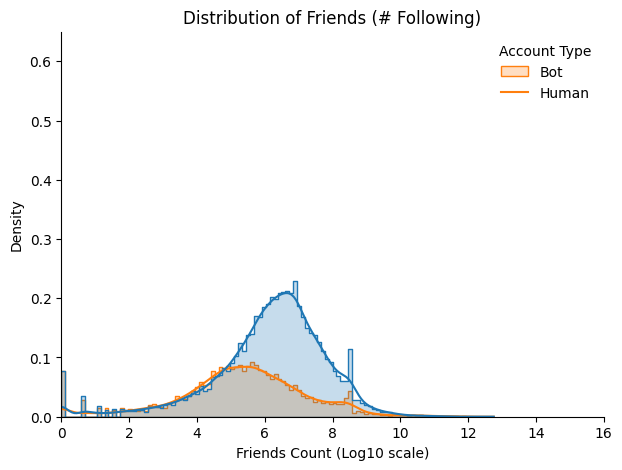

In [22]:
plt.figure(figsize=(7,5), dpi=100)
sns.histplot(x='following_log', data=df, hue='bot', alpha=.25, 
             kde=True, stat='density', common_bins=True, element='step', legend=True)

plt.legend(title='Account Type', loc='upper right', labels=['Bot', 'Human'], frameon=False)
plt.title('Distribution of Friends (# Following)', fontsize=12)
plt.xlabel('Friends Count (Log10 scale)', fontsize=10)
plt.ylabel('Density', fontsize=10)
plt.xlim(0, 16)
plt.ylim(0, 0.65)
sns.despine()

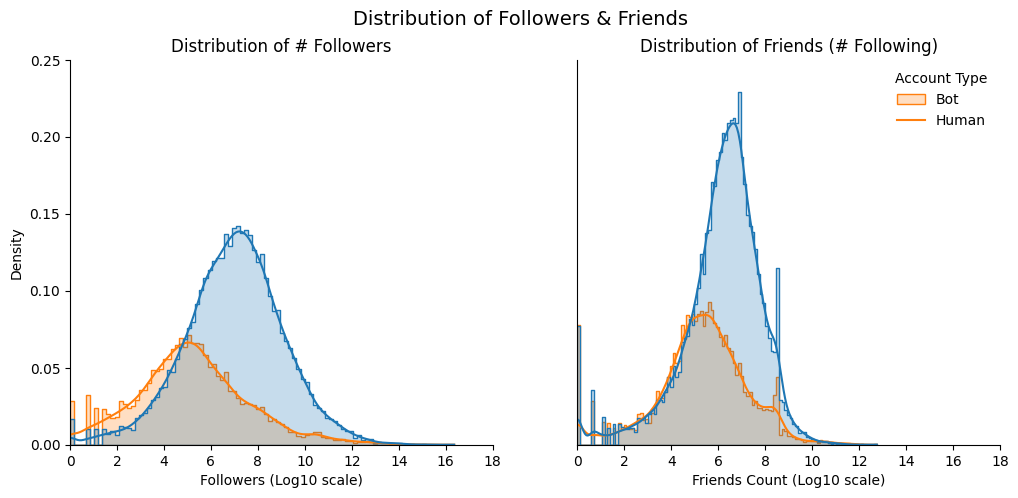

In [23]:
plt.figure(figsize=(12,5), dpi=100)
plt.suptitle('Distribution of Followers & Friends', fontsize=14)

plt.subplot(1, 2, 1)
sns.histplot(x='follower_log', data=df, hue='bot', alpha=.25, 
             kde=True, stat='density', common_bins=True, element='step', legend=False)
plt.title('Distribution of # Followers', fontsize=12)
plt.xlabel('Followers (Log10 scale)', fontsize=10)
plt.ylabel('Density', fontsize=10)
plt.xlim(0, 18)
plt.ylim(0, 0.25)
sns.despine()

plt.subplot(1, 2, 2)
sns.histplot(x='following_log', data=df, hue='bot', alpha=.25, 
             kde=True, stat='density', common_bins=True, element='step', legend=True)

plt.legend(title='Account Type', loc='upper right', labels=['Bot', 'Human'], frameon=False)
plt.title('Distribution of Friends (# Following)', fontsize=12)
plt.xlabel('Friends Count (Log10 scale)', fontsize=10)
plt.ylabel("")
plt.yticks([])
plt.xlim(0, 18)
plt.ylim(0, 0.25)
sns.despine()

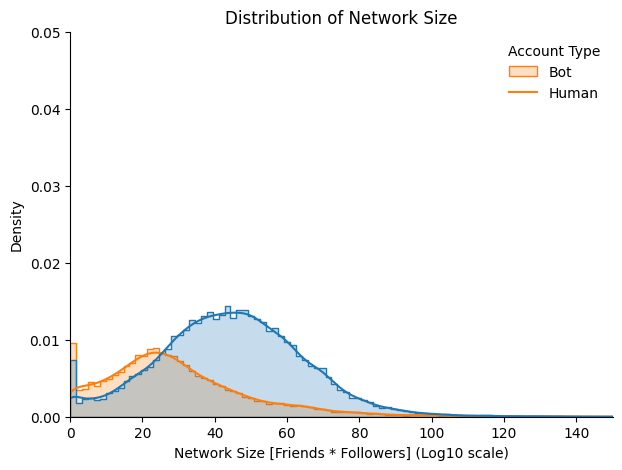

In [24]:
plt.figure(figsize=(7,5), dpi=100)
sns.histplot(x='network', data=df, hue='bot', alpha=.25, 
             kde=True, stat='density', common_bins=True, element='step', legend=True)

plt.legend(title='Account Type', loc='upper right', labels=['Bot', 'Human'], frameon=False)
plt.title('Distribution of Network Size', fontsize=12)
plt.xlabel('Network Size [Friends * Followers] (Log10 scale)', fontsize=10)
plt.ylabel('Density', fontsize=10)
plt.xlim(0, 150)
plt.ylim(0, 0.05)
sns.despine()

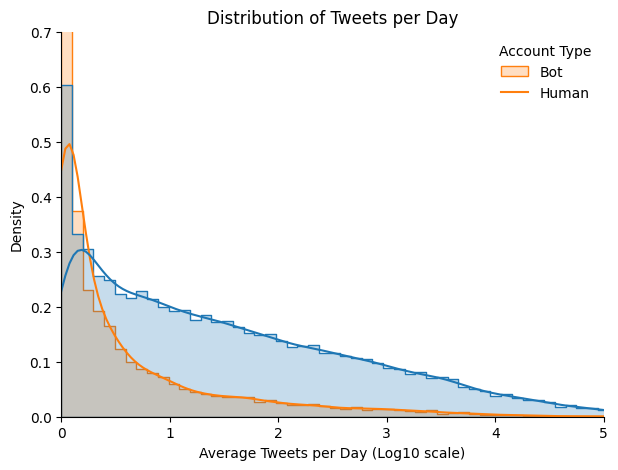

In [25]:
plt.figure(figsize=(7,5), dpi=100)
sns.histplot(x='avg_daily_tweets_log', data=df, hue='bot', alpha=.25, 
             kde=True, stat='density', common_bins=True, element='step', legend=True)

plt.legend(title='Account Type', loc='upper right', labels=['Bot', 'Human'], frameon=False)
plt.title("Distribution of Tweets per Day", fontsize=12)
plt.xlabel('Average Tweets per Day (Log10 scale)', fontsize=10)
plt.ylabel('Density', fontsize=10)
plt.xlim(0, 5)
plt.ylim(0, 0.7)
sns.despine()

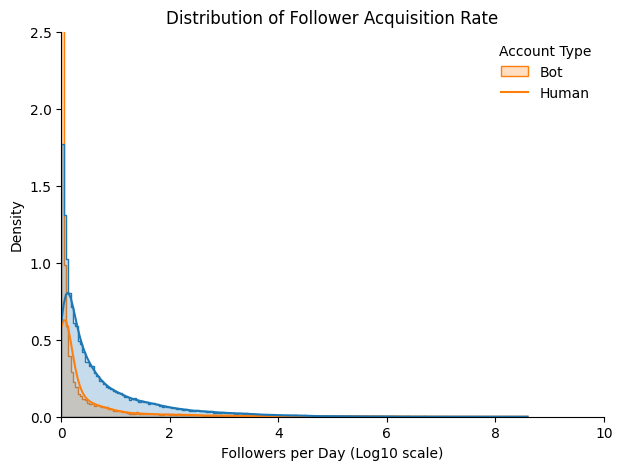

In [26]:
plt.figure(figsize=(7,5), dpi=100)
sns.histplot(x='follower_acq_rate', data=df, hue='bot', alpha=.25, 
             kde=True, stat='density', common_bins=True, element='step', legend=True)

plt.legend(title='Account Type', loc='upper right', labels=['Bot', 'Human'], frameon=False)
plt.title("Distribution of Follower Acquisition Rate", fontsize=12)
plt.xlabel('Followers per Day (Log10 scale)', fontsize=10)
plt.ylabel('Density', fontsize=10)
plt.xlim(0, 10)
plt.ylim(0, 2.5)
sns.despine()

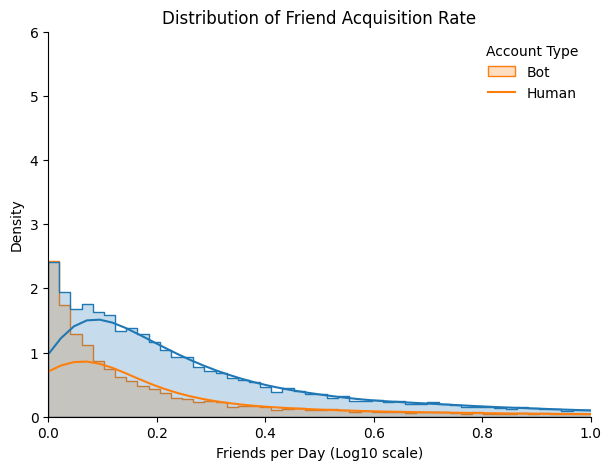

In [27]:
plt.figure(figsize=(7,5), dpi=100)
sns.histplot(x='friends_acq_rate', data=df, hue='bot', alpha=.25, 
             kde=True, stat='density', common_bins=True, element='step', legend=True)

plt.legend(title='Account Type', loc='upper right', labels=['Bot', 'Human'], frameon=False)
plt.title("Distribution of Friend Acquisition Rate", fontsize=12)
plt.xlabel('Friends per Day (Log10 scale)', fontsize=10)
plt.ylabel('Density', fontsize=10)
plt.xlim(0, 1)
plt.ylim(0, 6)
sns.despine()

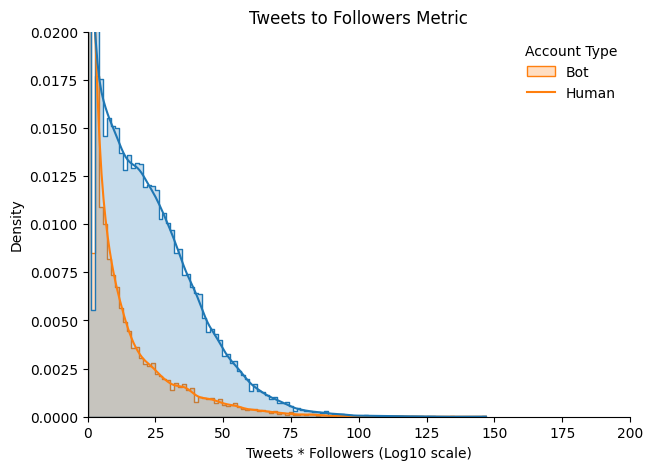

In [28]:
plt.figure(figsize=(7,5), dpi=100)
sns.histplot(x='tweet_to_followers', data=df, hue='bot', alpha=.25, 
             kde=True, stat='density', common_bins=True, element='step', legend=True)

plt.legend(title='Account Type', loc='upper right', labels=['Bot', 'Human'], frameon=False)
plt.title("Tweets to Followers Metric", fontsize=12)
plt.xlabel('Tweets * Followers (Log10 scale)', fontsize=10)
plt.ylabel('Density', fontsize=10)
plt.xlim(0, 200)
plt.ylim(0, 0.02)
sns.despine()

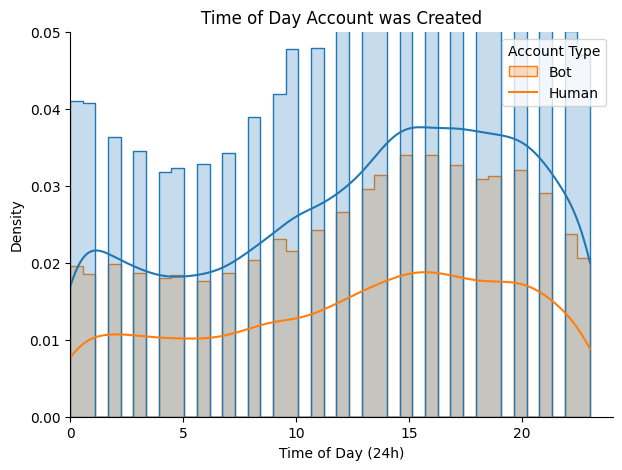

In [29]:
plt.figure(figsize=(7,5), dpi=100)
sns.histplot(x='hour_created', data=df, hue='bot', alpha=.25, 
             kde=True, stat='density', common_bins=True, element='step', legend=True)

plt.legend(title='Account Type', loc='best', labels=['Bot', 'Human'])
plt.title("Time of Day Account was Created", fontsize=12)
plt.xlabel('Time of Day (24h)', fontsize=10)
plt.ylabel('Density', fontsize=10)
plt.xlim(0, 24)
plt.ylim(0, 0.05)
sns.despine()

In [30]:
df.columns

Index(['bot', 'hour_created', 'verified', 'geo_enabled',
       'default_profile_image', 'following_count', 'follower_count',
       'listed_count', 'pinned_tweet', 'protected', 'description_urls_count',
       'description_mentions_count', 'account_age_days',
       'average_tweets_per_day', 'avg_daily_followers', 'avg_daily_friends',
       'avg_daily_favorites', 'following_log', 'follower_log',
       'avg_daily_tweets_log', 'network', 'tweet_to_followers',
       'follower_acq_rate', 'friends_acq_rate', 'favs_rate'],
      dtype='object')

In [31]:
features = ['verified', 
            'geo_enabled', 
            'protected',
            'pinned_tweet',
            # 'default_profile', 
            'default_profile_image', 
            # 'favourites_count', 
            'follower_count', 
            'following_count', 
            'listed_count', 
            'average_tweets_per_day',
            #'avg_daily_followers', 
            #'avg_daily_friends',
            #'avg_daily_favorites',
            # 'network', 
            'tweet_to_followers', 
            'follower_acq_rate', 
            'friends_acq_rate',
            # 'favs_rate',
            'hour_created',
           ]

X = df[features]
y = df['bot']

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from model_evaluation import *

In [33]:
X, X_test, y, y_test = train_test_split(X, y, test_size=.3, random_state=1234)

## Basic model evaluation

* KNearestNeighbors
* LogisticRegression
* NaiveBayes (Gaussian, Bernoulli, Multinomial)
* DecicionTree
* RandomForest
* XGBoost

In [34]:
# Models that require scaling: 
knn = KNeighborsClassifier(n_neighbors=10)
lr = LogisticRegression()

# Scaling
scalar = StandardScaler()
scalar.fit(X)
X_train_scaled = scalar.transform(X)

model_list = [knn, lr]
kf = KFold(n_splits=5, shuffle=True, random_state=33)

In [35]:
multi_model_eval(model_list, X_train_scaled, y, kf)

Model: KNeighborsClassifier(n_neighbors=10)
------------------------------
Accuracy:  0.72321 +- 0.007034
Precision: 0.62609 +- 0.012919
Recall:    0.42665 +- 0.010737
F1 Score:  0.50733 +- 0.007860
ROC AUC:   0.75909 +- 0.004560

Model: LogisticRegression()
------------------------------
Accuracy:  0.72971 +- 0.007483
Precision: 0.66395 +- 0.022280
Recall:    0.38707 +- 0.012137
F1 Score:  0.48891 +- 0.013654
ROC AUC:   0.77600 +- 0.007210



In [36]:
gnb = GaussianNB()
bnb = BernoulliNB()
mnb = MultinomialNB()
tree = DecisionTreeClassifier()
forest = RandomForestClassifier()
xgb = XGBClassifier()

model_list = [gnb, bnb, mnb, tree, forest, xgb]
kf = KFold(n_splits=3, shuffle=True, random_state=33)

In [37]:
multi_model_eval(model_list, X, y, kf)

Model: GaussianNB()
------------------------------
Accuracy:  0.66756 +- 0.017106
Precision: 0.54298 +- 0.070260
Recall:    0.55814 +- 0.306070
F1 Score:  0.47195 +- 0.185635
ROC AUC:   0.74332 +- 0.005239

Model: BernoulliNB()
------------------------------
Accuracy:  0.69629 +- 0.001673
Precision: 0.55595 +- 0.010142
Recall:    0.45208 +- 0.003275
F1 Score:  0.49861 +- 0.004293
ROC AUC:   0.71173 +- 0.005626

Model: MultinomialNB()
------------------------------
Accuracy:  0.52044 +- 0.006439
Precision: 0.39001 +- 0.005496
Recall:    0.77212 +- 0.015756
F1 Score:  0.51820 +- 0.007107
ROC AUC:   0.54087 +- 0.012069

Model: DecisionTreeClassifier()
------------------------------
Accuracy:  0.69584 +- 0.001619
Precision: 0.54400 +- 0.011993
Recall:    0.55283 +- 0.006346
F1 Score:  0.54837 +- 0.009169
ROC AUC:   0.66019 +- 0.003750

Model: RandomForestClassifier()
------------------------------
Accuracy:  0.76463 +- 0.002529
Precision: 0.68036 +- 0.010666
Recall:    0.55690 +- 0.008472


Average AUC Score: 0.8253 +- 0.003244


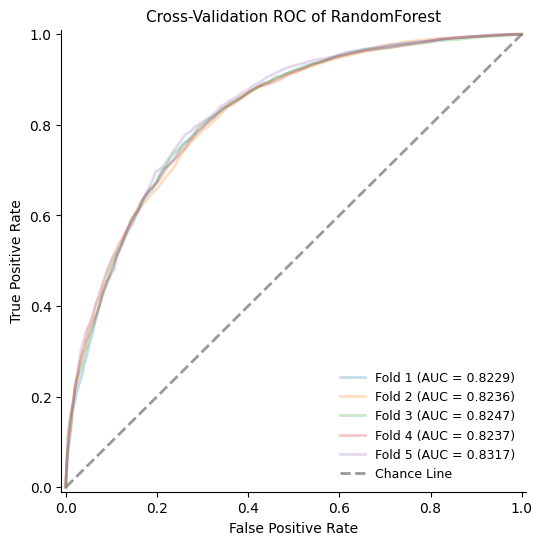

In [38]:
forest = RandomForestClassifier()
kf = KFold(n_splits=5, shuffle=True, random_state=33)

roc_curve_cv(forest, X, y, kf, model_alias='RandomForest')

Average Precision Score: 0.6776 +- 0.009308
Average Recall Score: 0.5596 +- 0.004907


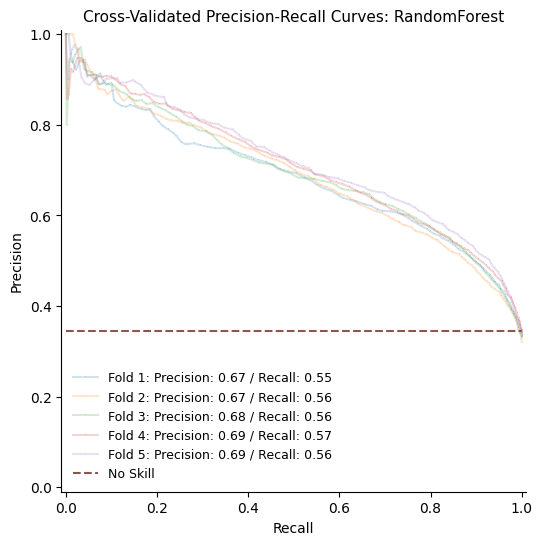

In [39]:
precision_recall_cv(forest, X, y, kf, model_alias='RandomForest')

Average AUC Score: 0.8264 +- 0.003797


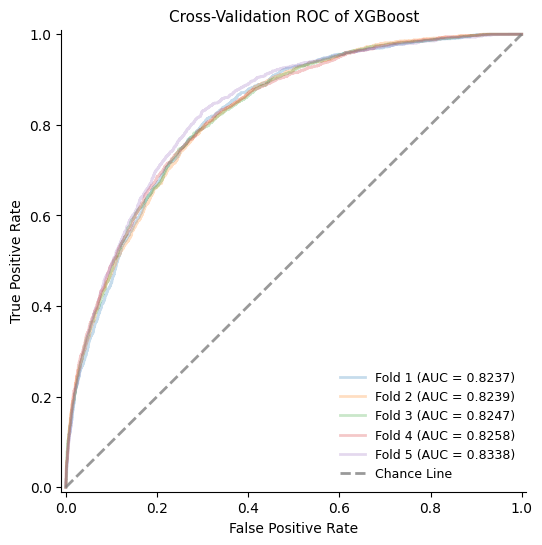

In [40]:
xgb = XGBClassifier()

kf = KFold(n_splits=5, shuffle=True, random_state=33)

roc_curve_cv(xgb, X, y, kf, model_alias='XGBoost')

Average Precision Score: 0.6675 +- 0.014984
Average Recall Score: 0.5781 +- 0.005792


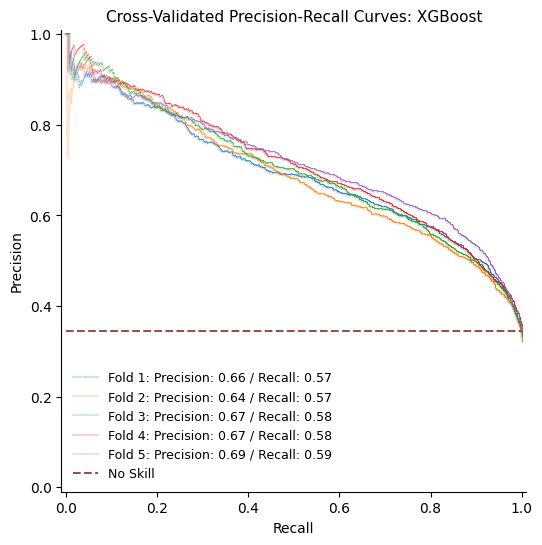

In [41]:
precision_recall_cv(xgb, X, y, kf, model_alias='XGBoost')

## Class weight balancing

In [42]:
num_bots = len(df[df['bot'] == 1])
num_humans = len(df[df['bot'] == 0])

print("Number of bots: ", num_bots)
print("Number of humans: ", num_humans)
print(f'Bots / Total %: {(num_bots / len(df))*100:.2f}')

Number of bots:  15000
Number of humans:  30000
Bots / Total %: 33.33


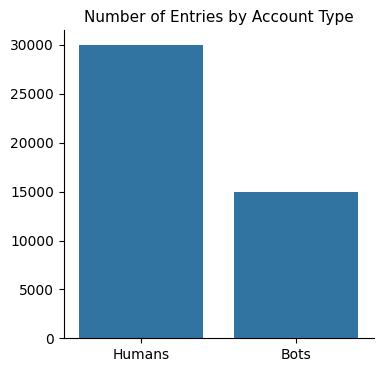

In [43]:
types = ['Humans', 'Bots']
counts = [num_humans, num_bots]

plt.figure(figsize=(4, 4))
sns.barplot(x = types, y = counts)
plt.title("Number of Entries by Account Type", fontsize=11)
sns.despine()

In [44]:
estimate = num_humans/num_bots
estimate

2.0

In [45]:
forest = RandomForestClassifier(class_weight='balanced')
xgb = XGBClassifier(scale_pos_weight=estimate)

models = [forest, xgb]
kf = KFold(n_splits=5, shuffle=True, random_state=33)

In [46]:
multi_model_eval(models, X, y, kf)

Model: RandomForestClassifier(class_weight='balanced')
------------------------------
Accuracy:  0.76413 +- 0.003038
Precision: 0.68696 +- 0.011380
Recall:    0.53975 +- 0.008470
F1 Score:  0.60450 +- 0.008925
ROC AUC:   0.82566 +- 0.003533

Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None

### Cross-Validated Precision-Recall and ROC Curves

#### Random Forest

Average AUC Score: 0.8253 +- 0.004376


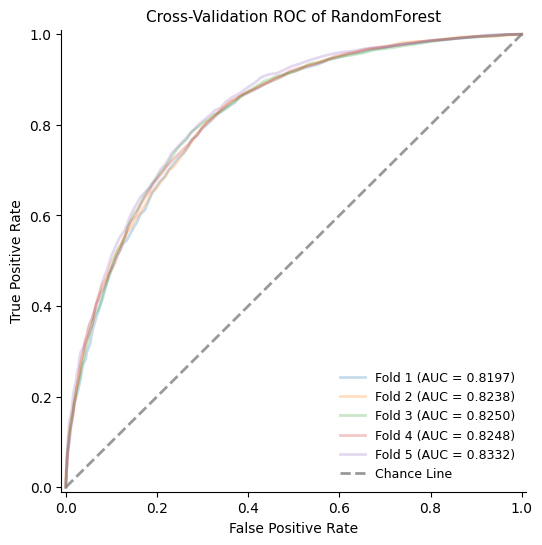

In [47]:
roc_curve_cv(forest, X, y, kf, model_alias='RandomForest')

Average Precision Score: 0.6880 +- 0.009194
Average Recall Score: 0.5391 +- 0.005372


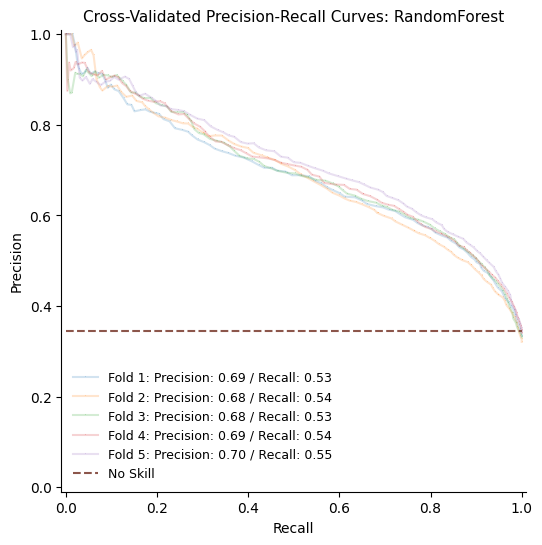

In [48]:
precision_recall_cv(forest, X, y, kf, model_alias='RandomForest')

#### XGBoost

Average AUC Score: 0.8264 +- 0.003034


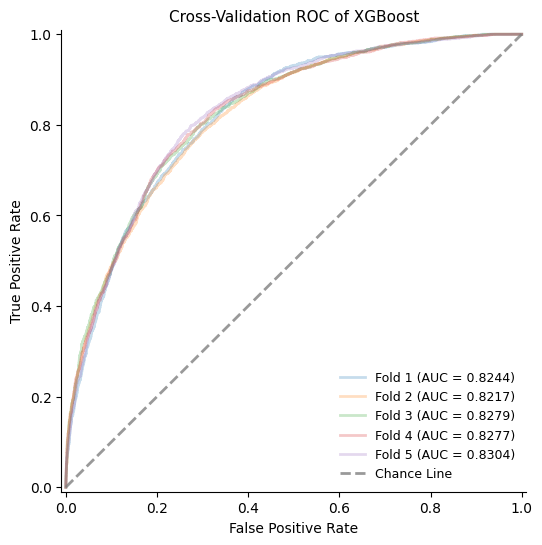

In [49]:
roc_curve_cv(xgb, X, y, kf, model_alias='XGBoost')

Average Precision Score: 0.6022 +- 0.016108
Average Recall Score: 0.7403 +- 0.007753


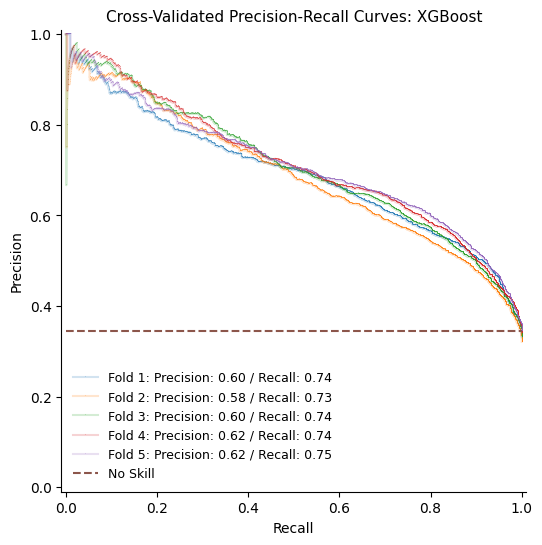

In [50]:
precision_recall_cv(xgb, X, y, kf, model_alias='XGBoost')

### Confusion Matrices

In [51]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3333)

#### Random Forest

In [52]:
forest = RandomForestClassifier(class_weight='balanced')

forest.fit(X_train, y_train)
preds = forest.predict(X_val)

Classification Metrics Report
-----------------------------
Accuracy:  0.7660
Precision: 0.6962
Recall:    0.5374
F1 Score:  0.6066

              precision    recall  f1-score   support

           0       0.79      0.88      0.83      5231
           1       0.70      0.54      0.61      2644

    accuracy                           0.77      7875
   macro avg       0.74      0.71      0.72      7875
weighted avg       0.76      0.77      0.76      7875




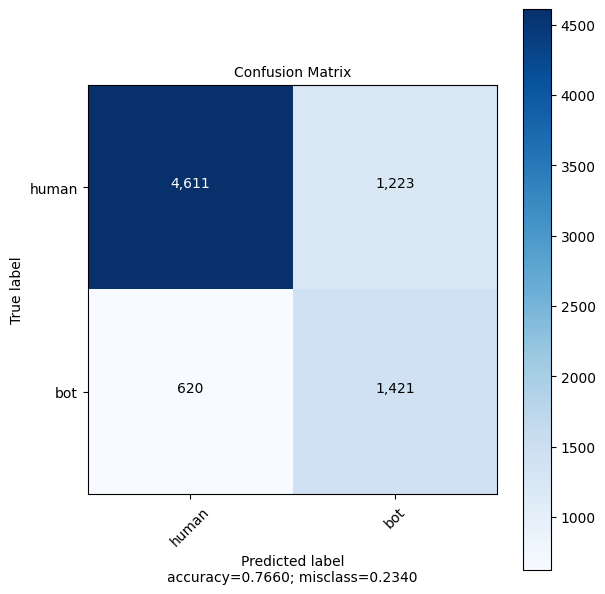

In [53]:
metrics_report(preds, y_val)

#### XGBoost

In [54]:
xgb = XGBClassifier(scale_pos_weight=estimate)

xgb.fit(X_train, y_train)
preds = xgb.predict(X_val)

Classification Metrics Report
-----------------------------
Accuracy:  0.7524
Precision: 0.6102
Recall:    0.7269
F1 Score:  0.6634

              precision    recall  f1-score   support

           0       0.85      0.77      0.80      5231
           1       0.61      0.73      0.66      2644

    accuracy                           0.75      7875
   macro avg       0.73      0.75      0.73      7875
weighted avg       0.77      0.75      0.76      7875




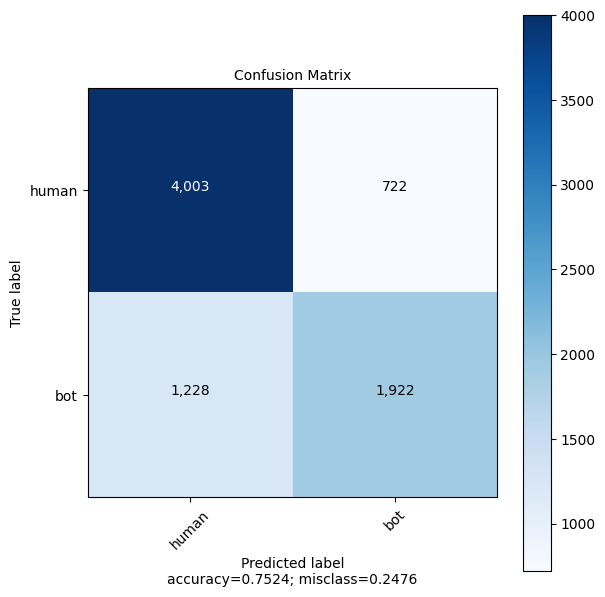

In [55]:
metrics_report(preds, y_val)

### Feature Importance

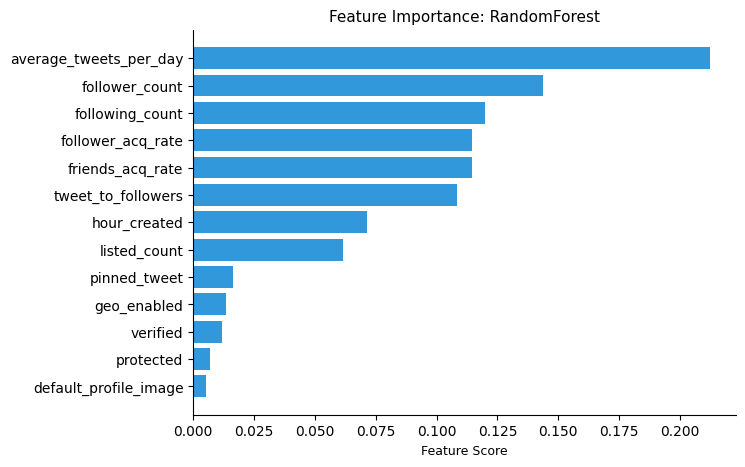

In [56]:
plot_feature_importance(forest, features, model_alias='RandomForest')

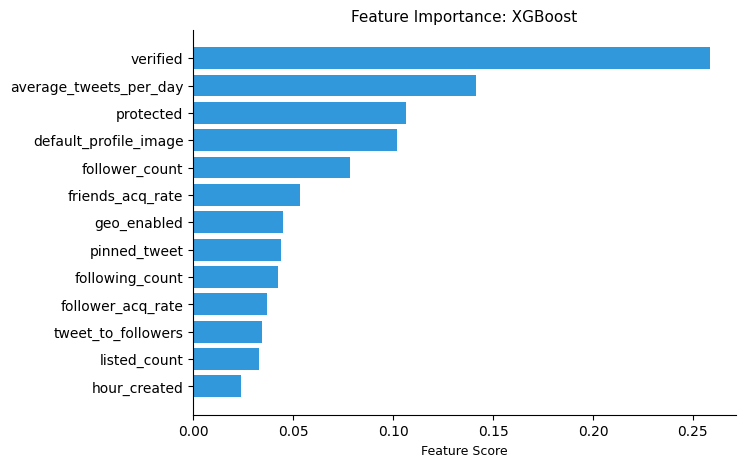

In [57]:
plot_feature_importance(xgb, features, model_alias='XGBoost')

In [58]:
features = ['verified', 
            'geo_enabled', 
            'protected',
            'pinned_tweet',
            'default_profile_image', 
            'follower_count', 
            'following_count', 
            'listed_count', 
            'average_tweets_per_day',
            'network', 
            'tweet_to_followers', 
            'follower_acq_rate', 
            'friends_acq_rate',
            'favs_rate',
            'hour_created',
           ]


X = df[features]
y = df['bot']

X, X_test, y, y_test = train_test_split(X, y, test_size=.3, random_state=1234)

In [59]:
xgb = XGBClassifier(scale_pos_weight=1.8, 
                    tree_method='hist', 
                    learning_rate=0.1,           
                    eta=0.01,                 
                    max_depth=7,                
                    gamma=0.05,
                    n_estimators=200,
                    colsample_bytree=.8
                   )

model_list = [xgb]

In [60]:
kf = KFold(n_splits=5, shuffle=True, random_state=33)

multi_model_eval(model_list, X, y, kf)

Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.01, eval_metric=None,
              feature_types=None, gamma=0.05, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)
------------------------------
Accuracy:  0.75689 +- 0.005630
Precision: 0.61506 +- 0.015418
Recall:    0.72712 +- 0.008620
F1 Score:  0.66638 +- 0.012582
ROC AUC:   0.83187 +- 0.003600



In [61]:
X.columns

Index(['verified', 'geo_enabled', 'protected', 'pinned_tweet',
       'default_profile_image', 'follower_count', 'following_count',
       'listed_count', 'average_tweets_per_day', 'network',
       'tweet_to_followers', 'follower_acq_rate', 'friends_acq_rate',
       'favs_rate', 'hour_created'],
      dtype='object')

In [62]:
import pickle

# Save the model to a file
with open('xgb_model.pkl', 'wb') as file:
    pickle.dump(xgb, file)